# Ablation Study: RL Agents for Fraud Detection

This notebook performs an ablation study to compare the performance of different Reinforcement Learning (RL) agents (PPO, A2C, DQN) on two fraud detection datasets (CreditCard and PaySim). 
We also evaluate the impact of different preprocessing techniques: Raw Data, PCA, and CTGAN Data Augmentation.

In [4]:
!pip install ctgan shimmy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.3/74.3 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 104.9 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 80.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 23.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 10.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 9.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 84.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━

In [5]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import pandas as pd
import torch
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.compose import ColumnTransformer

from stable_baselines3 import PPO, A2C, DQN
from stable_baselines3.common.vec_env import DummyVecEnv
from ctgan import CTGAN

# Set random seed for reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

# Define a learning rate schedule
def linear_schedule(initial_value):
    def schedule(progress_remaining):
        return progress_remaining * initial_value
    return schedule


/usr/local/lib/python3.11/dist-packages/rdt/transformers/utils.py:18: DeprecationWarning: module 'sre_parse' is deprecated
  import sre_parse  # isort:skip


## 1. Custom RL Environment

In [6]:
class FraudDetectionEnv(gym.Env):
    """
    A custom Gym environment for Fraud Detection.
    State: Feature vector of a transaction.
    Action: 0 (Declare Not Fraud), 1 (Declare Fraud).
    Reward: Based on correctly/incorrectly classifying fraud vs non-fraud.
    """
    def __init__(self, features: np.ndarray, labels: np.ndarray, reward_config: dict = None):
        super().__init__()
        
        if reward_config is None:
            # Default reward configuration favoring recall of fraud
            self.reward_config = {
    'TP': 10.0,
    'FP': -5.0,
    'FN': -20.0,
    'TN': 1.0
}

        else:
            self.reward_config = reward_config

        self.features = features.astype(np.float32)
        self.labels = labels.astype(np.int64)

        self.num_instances = self.features.shape[0]
        self.feature_dim = self.features.shape[1]

        # Action Space: Discrete(2) -> 0 for Not Fraud, 1 for Fraud
        self.action_space = spaces.Discrete(2)

        # Observation Space: Box(low, high, shape, dtype)
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, 
            shape=(self.feature_dim,), 
            dtype=np.float32
        )

        self._current_index = 0
        self._order = np.arange(self.num_instances)
        np.random.shuffle(self._order)

    def step(self, action: int):
        if self._current_index >= self.num_instances:
            return self.observation_space.sample() * 0, 0, True, False, {}

        actual_index = self._order[self._current_index]
        true_label = self.labels[actual_index]

        # Calculate Reward
        reward = 0
        if action == 1 and true_label == 1:
            reward = self.reward_config['TP']
        elif action == 1 and true_label == 0:
            reward = self.reward_config['FP']
        elif action == 0 and true_label == 1:
            reward = self.reward_config['FN']
        elif action == 0 and true_label == 0:
            reward = self.reward_config['TN']

        self._current_index += 1
        done = self._current_index >= self.num_instances
        truncated = False

        next_observation = np.zeros(self.feature_dim, dtype=np.float32)
        if not done:
             next_observation = self.features[self._order[self._current_index]]

        info = {
            'true_label': true_label,
            'predicted_action': action,
            'is_done': done
        }

        return next_observation, reward, done, truncated, info

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self._current_index = 0
        self._order = np.arange(self.num_instances)
        np.random.shuffle(self._order)
        
        initial_observation = self.features[self._order[self._current_index]]
        return initial_observation, {}

## 2. Data Loading and Preprocessing

In [7]:
def load_creditcard_data(path="creditcard.csv"):
    print("Loading CreditCard dataset...")
    df = pd.read_csv(path)
    
    # 1. Balance Data (1:5 Fraud to Non-Fraud)
    fraud = df[df['Class'] == 1]
    non_fraud = df[df['Class'] == 0]
    
    # Undersample non-fraud
    n_fraud = len(fraud)
    n_non_fraud = n_fraud * 5
    
    if len(non_fraud) > n_non_fraud:
        non_fraud = non_fraud.sample(n=n_non_fraud, random_state=SEED)
    
    balanced_df = pd.concat([fraud, non_fraud]).sample(frac=1, random_state=SEED).reset_index(drop=True)
    print(f"Balanced CreditCard Data: {len(fraud)} Fraud, {len(non_fraud)} Non-Fraud")

    # 2. Split
    X = balanced_df.drop('Class', axis=1).values
    y = balanced_df['Class'].values
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)
    
    # 3. Scale (Fit on Train, Transform Test)
    # Scale Time (0) and Amount (29)
    def scale_columns(X_tr, X_te, indices):
        for i in indices:
            scaler_i = StandardScaler()
            X_tr[:, i] = scaler_i.fit_transform(X_tr[:, i].reshape(-1, 1)).flatten()
            X_te[:, i] = scaler_i.transform(X_te[:, i].reshape(-1, 1)).flatten()
        return X_tr, X_te

    if X_train.shape[1] == 30:
        X_train, X_test = scale_columns(X_train, X_test, [0, 29])
    
    return X_train, X_test, y_train, y_test

def load_paysim_data(path="paysim.csv"):
    print("Loading PaySim dataset...")
    df = pd.read_csv(path)
    
    # Drop unnecessary columns
    df = df.drop(['nameOrig', 'nameDest', 'isFlaggedFraud'], axis=1)
    
    # Rename 'isFraud' to 'Class' for consistency
    df = df.rename(columns={'isFraud': 'Class'})
    
    # One-hot encode 'type'
    df = pd.get_dummies(df, columns=['type'], drop_first=True)
    
    # 1. Balance Data (1:5 Fraud to Non-Fraud)
    fraud = df[df['Class'] == 1]
    non_fraud = df[df['Class'] == 0]
    
    # Undersample non-fraud
    n_fraud = len(fraud)
    n_non_fraud = n_fraud * 5
    
    if len(non_fraud) > n_non_fraud:
        non_fraud = non_fraud.sample(n=n_non_fraud, random_state=SEED)
        
    balanced_df = pd.concat([fraud, non_fraud]).sample(frac=1, random_state=SEED).reset_index(drop=True)
    print(f"Balanced PaySim Data: {len(fraud)} Fraud, {len(non_fraud)} Non-Fraud")
    
    # 2. Split
    X = balanced_df.drop('Class', axis=1).values.astype(np.float32)
    y = balanced_df['Class'].values.astype(np.int64)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)
    
    # 3. Scale
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    return X_train, X_test, y_train, y_test


## 3. Preprocessing Techniques (PCA & CTGAN)

In [8]:
def apply_pca_ctgan(X_train, y_train, X_test, n_components=0.99, epochs=200):
    print(f"Applying PCA (n_components={n_components}) + CTGAN (epochs={epochs})...")
    
    # 1. Apply PCA
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    print(f"PCA reduced dimensions from {X_train.shape[1]} to {X_train_pca.shape[1]}")
    
    # 2. Apply CTGAN on PCA-transformed data
    # Combine X and y for CTGAN
    df_train = pd.DataFrame(X_train_pca, columns=[f'f{i}' for i in range(X_train_pca.shape[1])])
    df_train['label'] = y_train
    
    # Filter fraud samples
    fraud_df = df_train[df_train['label'] == 1].drop('label', axis=1)
    
    if len(fraud_df) == 0:
        print("No fraud samples found for CTGAN!")
        return X_train_pca, y_train, X_test_pca
        
    # Train CTGAN
    ctgan = CTGAN(epochs=epochs, batch_size=64, pac=1, verbose=True)
    ctgan.fit(fraud_df)
    
    # Generate synthetic samples to balance the dataset (or double the fraud count)
    n_synthetic = len(fraud_df) 
    synthetic_fraud = ctgan.sample(n_synthetic)
    
    X_synthetic = synthetic_fraud.values
    y_synthetic = np.ones(n_synthetic)
    
    X_aug = np.vstack([X_train_pca, X_synthetic])
    y_aug = np.concatenate([y_train, y_synthetic])
    
    print(f"Augmented training set from {len(X_train_pca)} to {len(X_aug)} samples.")
    return X_aug, y_aug, X_test_pca


## 4. Experiment Loop

In [9]:
def train_and_evaluate(agent_name, X_train, y_train, X_test, y_test, total_timesteps=10000):
    # Create Environment
    env = DummyVecEnv([lambda: FraudDetectionEnv(X_train, y_train)])
    
    # Initialize Agent
    if agent_name == 'PPO':
        # Default PPO parameters as none were specified in reference
        model = PPO('MlpPolicy', env, verbose=0)
    elif agent_name == 'A2C':
        model = A2C(
            "MlpPolicy",
            env,
            learning_rate=1e-4,
            gamma=0.99,
            n_steps=5,
            ent_coef=0.01,
            vf_coef=0.5,
            max_grad_norm=0.5,
            verbose=0,
            device="auto"
        )
    elif agent_name == 'DQN':
        model = DQN(
            "MlpPolicy",
            env,
            learning_rate=linear_schedule(1e-4),
            buffer_size=100000,
            learning_starts=1000,
            batch_size=512,
            gamma=0.99,
            train_freq=1,
            gradient_steps=1,
            target_update_interval=500,
            exploration_fraction=0.1,
            exploration_initial_eps=1.0,
            exploration_final_eps=0.05,
            max_grad_norm=10,
            verbose=0,
            device="auto"
        )
    else:
        raise ValueError(f"Unknown agent: {agent_name}")
    
    # Train
    model.learn(total_timesteps=total_timesteps)
    
    # Evaluate
    # We'll use the environment logic to step through test set
    test_env = FraudDetectionEnv(X_test, y_test)
    obs, _ = test_env.reset()
    
    y_pred = []
    y_true = []
    
    done = False
    while not done:
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, truncated, info = test_env.step(action)
        
        if 'true_label' in info:
            y_true.append(info['true_label'])
            y_pred.append(action)
            
    # Metrics
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    
    return precision, recall, f1


In [10]:
# Configuration
datasets = ['CreditCard', 'PaySim']
preprocessing_methods = ['Raw', 'PCA_CTGAN']
agents = ['PPO', 'A2C', 'DQN']

results = []

for dataset_name in datasets:
    print(f"\n=== Processing Dataset: {dataset_name} ===")
    
    # Load Data
    if dataset_name == 'CreditCard':
        X_train, X_test, y_train, y_test = load_creditcard_data("/kaggle/input/creditcardfraud/creditcard.csv")
    else:
        X_train, X_test, y_train, y_test = load_paysim_data("/kaggle/input/paysim1/PS_20174392719_1491204439457_log.csv")
        
        # Subsample PaySim for speed if it's too large (optional, but recommended for quick ablation)
        # PaySim is huge, so let's take a subset for this study
        if len(X_train) > 500000:
            print("Subsampling PaySim to 500k samples for speed...")
            indices = np.random.choice(len(X_train), 500000, replace=False)
            X_train = X_train[indices]
            y_train = y_train[indices]
            # Also subsample test
            test_indices = np.random.choice(len(X_test), 100000, replace=False)
            X_test = X_test[test_indices]
            y_test = y_test[test_indices]

    # Store original copies
    X_train_orig, X_test_orig = X_train.copy(), X_test.copy()
    y_train_orig = y_train.copy()

    for prep in preprocessing_methods:
        print(f"\n--- Preprocessing: {prep} ---")
        
        # Reset data
        X_curr_train, X_curr_test = X_train_orig.copy(), X_test_orig.copy()
        y_curr_train = y_train_orig.copy()
        
        # Apply Preprocessing
        if prep == 'PCA_CTGAN':
            X_curr_train, y_curr_train, X_curr_test = apply_pca_ctgan(X_curr_train, y_curr_train, X_curr_test, epochs=200)
            
        for agent in agents:
            print(f"Training {agent}...")
            try:
                prec, rec, f1 = train_and_evaluate(agent, X_curr_train, y_curr_train, X_curr_test, y_test, total_timesteps=5000)
                print(f"Result: F1={f1:.4f} (Prec={prec:.4f}, Rec={rec:.4f})")
                
                results.append({
                    'Dataset': dataset_name,
                    'Preprocessing': prep,
                    'Agent': agent,
                    'Precision': prec,
                    'Recall': rec,
                    'F1': f1
                })
            except Exception as e:
                print(f"Failed to train {agent}: {e}")



=== Processing Dataset: CreditCard ===
Loading CreditCard dataset...
Balanced CreditCard Data: 492 Fraud, 2460 Non-Fraud

--- Preprocessing: Raw ---
Training PPO...
Result: F1=0.7667 (Prec=0.6479, Rec=0.9388)
Training A2C...
Result: F1=0.6460 (Prec=0.4870, Rec=0.9592)
Training DQN...
Result: F1=0.9355 (Prec=0.9886, Rec=0.8878)

--- Preprocessing: PCA_CTGAN ---
Applying PCA (n_components=0.99) + CTGAN (epochs=200)...
PCA reduced dimensions from 30 to 24


Gen. (-1.22) | Discrim. (-0.19): 100%|██████████| 200/200 [00:38<00:00,  5.26it/s]


Augmented training set from 2361 to 2755 samples.
Training PPO...
Result: F1=0.8708 (Prec=0.8198, Rec=0.9286)
Training A2C...
Result: F1=0.9175 (Prec=0.9271, Rec=0.9082)
Training DQN...
Result: F1=0.8911 (Prec=0.8654, Rec=0.9184)

=== Processing Dataset: PaySim ===
Loading PaySim dataset...
Balanced PaySim Data: 8213 Fraud, 41065 Non-Fraud

--- Preprocessing: Raw ---
Training PPO...
Result: F1=0.6854 (Prec=0.5757, Rec=0.8466)
Training A2C...
Result: F1=0.6718 (Prec=0.5834, Rec=0.7918)
Training DQN...
Result: F1=0.7020 (Prec=0.6672, Rec=0.7407)

--- Preprocessing: PCA_CTGAN ---
Applying PCA (n_components=0.99) + CTGAN (epochs=200)...
PCA reduced dimensions from 10 to 8


Gen. (-0.05) | Discrim. (-0.19): 100%|██████████| 200/200 [05:42<00:00,  1.71s/it]


Augmented training set from 39422 to 45992 samples.
Training PPO...
Result: F1=0.5086 (Prec=0.3453, Rec=0.9647)
Training A2C...
Result: F1=0.5243 (Prec=0.3649, Rec=0.9306)
Training DQN...
Result: F1=0.7055 (Prec=0.6381, Rec=0.7888)


## 5. Results Visualization

In [13]:
# Create DataFrame from results sorted by F1 score
results_df = pd.DataFrame(results)
sorted_results_df = results_df.sort_values(by='F1', ascending=False)

print("\n=== Final Results ===")
(results_df)


=== Final Results ===


,Dataset,Preprocessing,Agent,Precision,Recall,F1
0,CreditCard,Raw,PPO,0.647887,0.938776,0.766667
1,CreditCard,Raw,A2C,0.487047,0.959184,0.646048
2,CreditCard,Raw,DQN,0.988636,0.887755,0.935484
3,CreditCard,PCA_CTGAN,PPO,0.819820,0.928571,0.870813
4,CreditCard,PCA_CTGAN,A2C,0.927083,0.908163,0.917526
5,CreditCard,PCA_CTGAN,DQN,0.865385,0.918367,0.891089
6,PaySim,Raw,PPO,0.575745,0.846622,0.685390
7,PaySim,Raw,A2C,0.583408,0.791844,0.671831
8,PaySim,Raw,DQN,0.667215,0.740718,0.702048
9,PaySim,PCA_CTGAN,PPO,0.345316,0.964699,0.508583


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if

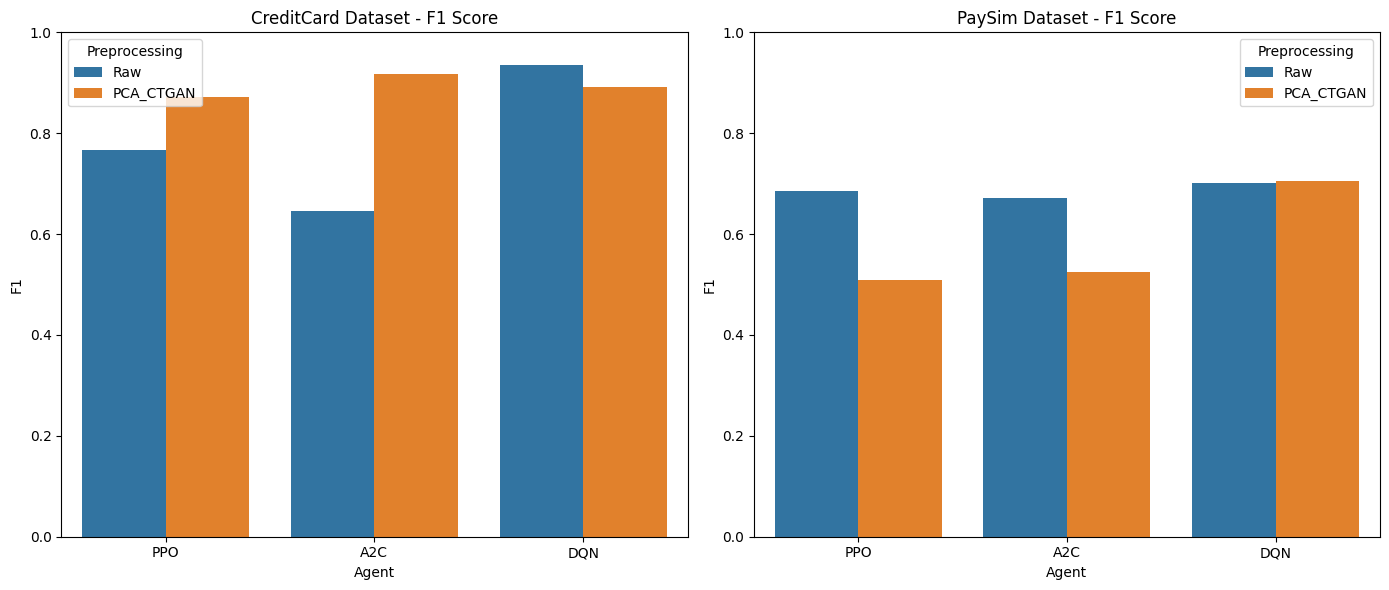

In [14]:
# Plotting
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.barplot(data=results_df[results_df['Dataset'] == 'CreditCard'], x='Agent', y='F1', hue='Preprocessing')
plt.title('CreditCard Dataset - F1 Score')
plt.ylim(0, 1)

plt.subplot(1, 2, 2)
sns.barplot(data=results_df[results_df['Dataset'] == 'PaySim'], x='Agent', y='F1', hue='Preprocessing')
plt.title('PaySim Dataset - F1 Score')
plt.ylim(0, 1)

plt.tight_layout()
plt.show()